In [3]:
import os
import sys
sys.path.append('../')

from google.cloud import bigquery
from google.oauth2 import service_account

from google.cloud import bigquery
from google.oauth2 import service_account

import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np

from authenticate_service_account import main
from utils import *


In [12]:
# client = main()

# query = """
# SELECT *
# FROM skyscanner-insights-343713.Itinerary_Scoring.top_10_ods
# """

# query_job = client.query(query)

# results = query_job.result()


In [13]:
# data = results.to_dataframe()


In [14]:
# data.to_csv('top_10_ods.csv', index=False)


In [4]:
data = pd.read_csv('../raw_data/top_10_ods.csv')


In [5]:
data.columns


Index(['OriginApt', 'OriginCty', 'OriginCtry', 'DestinationApt',
       'DestinationCty', 'DestinationCtry', 'TravelHorizonDays',
       'TravelDistanceKm', 'SelfTransfer', 'Stops', 'DurationMin',
       'Seg_0_OriginIATA', 'Seg_0_OriginName', 'Seg_0_DestinationIATA',
       'Seg_0_DestinationName', 'Seg_0_OperatingCarrierIATA',
       'Seg_0_TravelDistanceKm', 'Seg_1_OriginIATA', 'Seg_1_OriginName',
       'Seg_1_DestinationIATA', 'Seg_1_DestinationName',
       'Seg_1_OperatingCarrierIATA', 'Seg_1_TravelDistanceKm',
       'Seg_2_OriginIATA', 'Seg_2_OriginName', 'Seg_2_DestinationIATA',
       'Seg_2_DestinationName', 'Seg_2_OperatingCarrierIATA',
       'Seg_2_TravelDistanceKm', 'Seg_3_OriginIATA', 'Seg_3_OriginName',
       'Seg_3_DestinationIATA', 'Seg_3_DestinationName',
       'Seg_3_OperatingCarrierIATA', 'Seg_3_TravelDistanceKm',
       'Seg_0_DurationMin', 'Seg_1_DurationMin', 'Seg_2_DurationMin',
       'Seg_3_DurationMin', 'passengers', 'SearchLowestRatio',
       'ItinLowe

In [6]:
def create_od_column(df, raw_od_columns):
    df['OD'] = df[raw_od_columns[0]] + df[raw_od_columns[1]]

    return df


In [7]:
data_with_od = create_od_column(data, ['OriginCty', 'DestinationCty'])


In [8]:
columns_for_model = ['OD', 'TravelDistanceKm', 'Stops', 'TravelHorizonDays',
                     'Seg_0_TravelDistanceKm', 'Seg_1_TravelDistanceKm', 'Seg_2_TravelDistanceKm', 'Seg_3_TravelDistanceKm',
                     'ItineraryRedirects', 'ODRedirects',
                     'Seg_0_DurationMin' ,'Seg_1_DurationMin', 'Seg_2_DurationMin', 'Seg_3_DurationMin', 'DurationMin']


In [9]:
model_data = data_with_od[columns_for_model].copy()
model_data


,OD,TravelDistanceKm,Stops,TravelHorizonDays,Seg_0_TravelDistanceKm,Seg_1_TravelDistanceKm,Seg_2_TravelDistanceKm,Seg_3_TravelDistanceKm,ItineraryRedirects,ODRedirects,Seg_0_DurationMin,Seg_1_DurationMin,Seg_2_DurationMin,Seg_3_DurationMin,DurationMin
0,DELBOM,1140,0,180,1140,NaN,NaN,NaN,5,5,135.0,NaN,NaN,NaN,135
1,HKGBKK,1689,0,279,1689,NaN,NaN,NaN,4,5,175.0,NaN,NaN,NaN,175
2,HKGBKK,1689,0,279,1689,NaN,NaN,NaN,1,5,195.0,NaN,NaN,NaN,195
3,HKGTPE,806,0,136,806,NaN,NaN,NaN,4,37,100.0,NaN,NaN,NaN,100
4,HKGTPE,806,0,136,806,NaN,NaN,NaN,3,37,115.0,NaN,NaN,NaN,115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28164,TYOBKK,4648,0,138,4648,NaN,NaN,NaN,7,21,430.0,NaN,NaN,NaN,430
28165,TYOBKK,4648,1,138,1257,3668.0,NaN,NaN,1,21,150.0,360.0,NaN,NaN,780
28166,TYOBKK,4648,1,138,1257,3668.0,NaN,NaN,1,21,150.0,335.0,NaN,NaN,645
28167,TYOBKK,4648,1,340,5357,1416.0,NaN,NaN,1,2,430.0,150.0,NaN,NaN,650


In [10]:
data_with_layover = calculate_total_layover_time(model_data)


In [11]:
clean_data = drop_neg_layover_time(data_with_layover)


<Axes: >

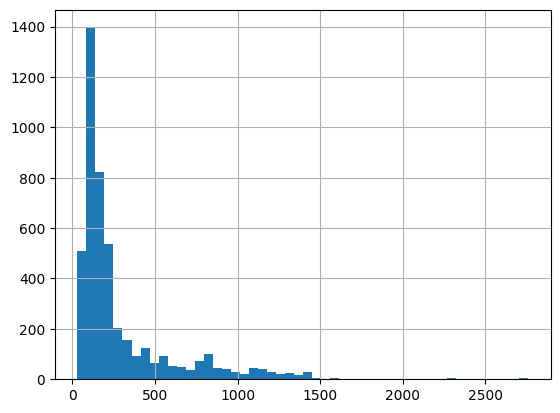

In [12]:

clean_data[clean_data['total_layover_time'] > 0]['total_layover_time'].hist(bins=50)


In [13]:
sorted_data = clean_data[clean_data['total_layover_time'] > 0]['total_layover_time'].sort_values()
cumulative = np.arange(1, len(sorted_data) +1) / len(sorted_data)


Text(0, 0.5, '% share of the data')

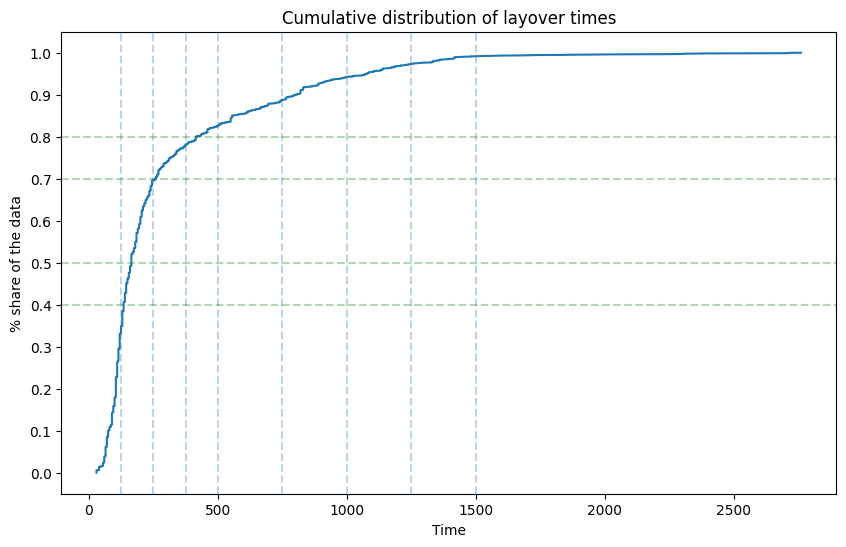

In [14]:
plt.figure(figsize=(10,6))
plt.plot(sorted_data, cumulative)
plt.yticks(np.linspace(0, 1, 11))
x_values = [125, 250, 375, 500, 750, 1000, 1250, 1500]  # Replace x1, x2, x3 with your specific values
for x in x_values:
    plt.axvline(x=x, linestyle='--', alpha=0.3)

y_values = [0.4, 0.5, 0.7, 0.8]
for y in y_values:
    plt.axhline(y=y, color='green', linestyle='--', alpha=0.3)

plt.title("Cumulative distribution of layover times")
plt.xlabel('Time')
plt.ylabel('% share of the data')


# Start from scratch with data 

## Running preprocessor

In [25]:
processed_data = preprocess(data, ['OriginCty', 'DestinationCty'])


NameError: name 'redirect_raio' is not defined

## Testing the binary encoder

In [16]:
import category_encoders as ce
# Initialize BinaryEncoder
binary_encoder = ce.BinaryEncoder(cols=["OD"])
# Fit and transform the data
binary_encoded_data = binary_encoder.fit_transform(model_data)
# Print the result
print("Binary Encoded data:")
print(binary_encoded_data)


Binary Encoded data:
       OD_0  OD_1  OD_2  OD_3  TravelDistanceKm  Stops  TravelHorizonDays  \
0         0     0     0     1              1140      0                180   
1         0     0     1     0              1689      0                279   
2         0     0     1     0              1689      0                279   
3         0     0     1     1               806      0                136   
4         0     0     1     1               806      0                136   
...     ...   ...   ...   ...               ...    ...                ...   
28164     1     0     1     0              4648      0                138   
28165     1     0     1     0              4648      1                138   
28166     1     0     1     0              4648      1                138   
28167     1     0     1     0              4648      1                340   
28168     1     0     1     0              4648      1                340   

       Seg_0_TravelDistanceKm  Seg_1_TravelDistanceKm 

In [17]:
corr_matrix = binary_encoded_data.corr()


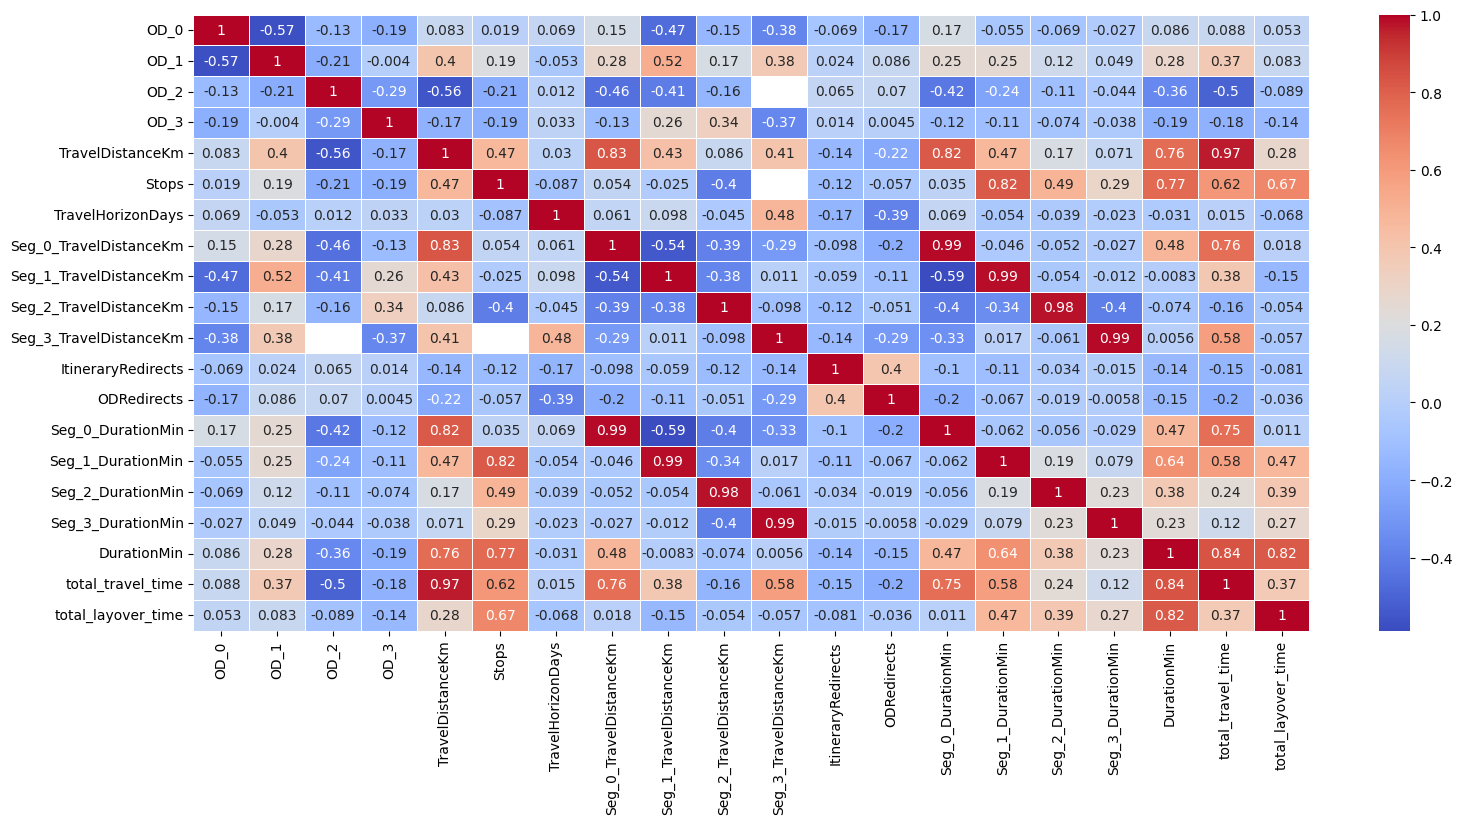

In [18]:
import seaborn as sns
plt.figure(figsize=(18,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.show()


In [19]:
random_forest_columns = ['OD_0', 'OD_1', 'OD_2', 'OD_3' , 'TravelDistanceKm', 'Stops', 'TravelHorizonDays',
                     'redirect_ratio', 'DurationMin', 'total_travel_time', 'total_layover_time']
